In [1]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.0 MB/s eta 0:00:00


In [2]:
import zipfile
import os

# Define the path to your zipped file
zipped_file_path = '/content/images1.zip'

# Define the directory where you want to extract the contents
extraction_directory = './extracted_content'

# Create the extraction directory if it doesn't exist
os.makedirs(extraction_directory, exist_ok=True)

try:
    with zipfile.ZipFile(zipped_file_path, 'r') as zip_ref:
        zip_ref.extractall(extraction_directory)
    print(f"Successfully unzipped '{zipped_file_path}' to '{extraction_directory}'")
except FileNotFoundError:
    print(f"Error: The file '{zipped_file_path}' was not found.")
except zipfile.BadZipFile:
    print(f"Error: '{zipped_file_path}' is not a valid zip file.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")


Successfully unzipped '/content/images1.zip' to './extracted_content'


In [4]:
import numpy as np
import torch
from PIL import Image
from tqdm import tqdm
from transformers import CLIPProcessor, CLIPModel
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import r2_score
import pandas as pd
import os

# --- CONFIGURATION ---
# We now point to the PROCESSED files generated by your EDA cell
TRAIN_PATH = 'train_processed.csv'
TEST_PATH = 'test_processed.csv'
IMG_DIR = '/content/extracted_content/images'#this is the unzipped images folder only
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# 1. LOAD PROCESSED DATA
print("Loading EDA-Processed Data...")
train_df = pd.read_csv(TRAIN_PATH)
test_df = pd.read_csv(TEST_PATH)

Loading EDA-Processed Data...


In [6]:
# --- MODULE 2: SEMANTIC VISUAL FEATURES (CLIP) ---
# We keep this because CLIP embeddings are generated from raw images, not the CSV.


class CLIPFeatureExtractor:
    def __init__(self):
        print("Initializing CLIP Model...")
        self.model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(DEVICE)
        self.processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

    def extract(self, df, img_dir):
        embeddings = []
        batch_size = 32
        for i in tqdm(range(0, len(df), batch_size)):
            batch_df = df.iloc[i : i+batch_size]
            images = []
            for idx, row in batch_df.iterrows():
                path = os.path.join(img_dir, f"{int(row['id'])}.jpg")
                if os.path.exists(path):
                    try:
                        img = Image.open(path).convert("RGB")
                        images.append(img)
                    except:
                        images.append(Image.new('RGB', (224, 224), color='black'))
                else:
                    images.append(Image.new('RGB', (224, 224), color='black'))

            inputs = self.processor(images=images, return_tensors="pt", padding=True).to(DEVICE)
            with torch.no_grad():
                image_features = self.model.get_image_features(**inputs)
                image_features = image_features / image_features.norm(p=2, dim=-1, keepdim=True)
            embeddings.append(image_features.cpu().numpy())

        return np.vstack(embeddings)

extractor = CLIPFeatureExtractor()
print("Extracting Visual Intelligence...")
train_embs = extractor.extract(train_df, IMG_DIR)
test_embs = extractor.extract(test_df, IMG_DIR)

# Add CLIP features to the DataFrames
emb_cols = [f"clip_{i}" for i in range(train_embs.shape[1])]
train_df = pd.concat([train_df, pd.DataFrame(train_embs, columns=emb_cols)], axis=1)
test_df = pd.concat([test_df, pd.DataFrame(test_embs, columns=emb_cols)], axis=1)

Initializing CLIP Model...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

Extracting Visual Intelligence...


100%|██████████| 169/169 [00:21<00:00,  7.69it/s]


In [17]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import pandas as pd

def apply_final_boost_features(train, test, k=15):
    # 1. Coordinate Rotation
    # This helps trees find clusters that aren't perfectly North-South
    for df in [train, test]:
        df['rot_45_x'] = df['lat'] + df['long']
        df['rot_45_y'] = df['lat'] - df['long']
        df['rot_30_x'] = (df['lat'] * np.cos(np.radians(30))) + (df['long'] * np.sin(np.radians(30)))
        df['rot_30_y'] = (df['long'] * np.cos(np.radians(30))) - (df['lat'] * np.sin(np.radians(30)))

    print("Applying Strategy 1: Safe Neighborhood Premium...")
    # 2. Spatial Intelligence (Anti-Leakage Version)
    coords = ['lat', 'long']
    nn = NearestNeighbors(n_neighbors=k, metric='haversine')
    nn.fit(np.radians(train[coords]))

    # Pre-calculate price context from Training data
    train_pp_sqft = (train['price'] / train['sqft_living']).values

    # Process TEST (Easy - just look at train neighbors)
    dist_test, idx_test = nn.kneighbors(np.radians(test[coords]))
    test['neighbor_price_per_sqft'] = train_pp_sqft[idx_test].mean(axis=1)
    test['neighbor_avg_grade'] = train['grade'].values[idx_test].mean(axis=1)
    test['grade_diff'] = test['grade'] - test['neighbor_avg_grade']

    # Process TRAIN (Hard - must exclude self to prevent 99.9% leakage)
    nn_train = NearestNeighbors(n_neighbors=k+1, metric='haversine')
    nn_train.fit(np.radians(train[coords]))
    _, idx_tr = nn_train.kneighbors(np.radians(train[coords]))

    # [:, 1:] excludes the house itself from its own neighborhood average
    train['neighbor_price_per_sqft'] = train_pp_sqft[idx_tr[:, 1:]].mean(axis=1)
    train['neighbor_avg_grade'] = train['grade'].values[idx_tr[:, 1:]].mean(axis=1)
    train['grade_diff'] = train['grade'] - train['neighbor_avg_grade']

    return train, test

# Execute the final refinements
train_df, test_df = apply_final_boost_features(train_df, test_df)

# --- CRITICAL: UPDATE FEATURE LIST ---
# We MUST drop 'price' and 'pp_sqft' to prevent the model from cheating
drop_cols = ['id', 'price', 'price_log', 'date', 'pp_sqft']
features = [c for c in train_df.columns if c in test_df.columns and c not in drop_cols]

print(f"Refinement Complete! Total Features for Model: {len(features)}")

Applying Strategy 1: Safe Neighborhood Premium...
Refinement Complete! Total Features for Model: 547


In [18]:
print("\n--- Training Hybrid CatBoost (Fusion of EDA + CLIP) ---")

target_col = 'price_log'
# Add 'pp_sqft' to drop_cols so it's not used for training, as it's not available for prediction
drop_cols = ['id', 'price', 'price_log', 'pp_sqft']
features = [c for c in train_df.columns if c not in drop_cols]

cat_features = ['geo_cluster', 'zipcode'] # Zipcode and Clusters are categorical

X = train_df[features]
y = train_df[target_col]

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

model_cb = CatBoostRegressor(
    iterations=2500,
    learning_rate=0.02,
    depth=7,
    eval_metric='R2',
    od_type='Iter',
    od_wait=100,
    task_type="GPU" if torch.cuda.is_available() else "CPU",
    verbose=250
)

model_cb.fit(X_train, y_train, eval_set=(X_val, y_val), cat_features=cat_features)


--- Training Hybrid CatBoost (Fusion of EDA + CLIP) ---


Default metric period is 5 because R2 is/are not implemented for GPU
Metric R2 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.0292348	test: 0.0292121	best: 0.0292121 (0)	total: 131ms	remaining: 5m 26s
250:	learn: 0.8997489	test: 0.8986516	best: 0.8986516 (250)	total: 18s	remaining: 2m 41s
500:	learn: 0.9085096	test: 0.9036794	best: 0.9036917 (495)	total: 34.2s	remaining: 2m 16s
750:	learn: 0.9128312	test: 0.9058770	best: 0.9058770 (750)	total: 50.3s	remaining: 1m 57s
1000:	learn: 0.9168846	test: 0.9070965	best: 0.9070965 (1000)	total: 1m 7s	remaining: 1m 40s
1250:	learn: 0.9194949	test: 0.9076951	best: 0.9077055 (1239)	total: 1m 24s	remaining: 1m 24s
1500:	learn: 0.9212055	test: 0.9080906	best: 0.9080928 (1490)	total: 1m 40s	remaining: 1m 7s
1750:	learn: 0.9225648	test: 0.9084616	best: 0.9084616 (1750)	total: 1m 57s	remaining: 50.2s
2000:	learn: 0.9237112	test: 0.9087013	best: 0.9087047 (1992)	total: 2m 13s	remaining: 33.4s
2250:	learn: 0.9246701	test: 0.9088599	best: 0.9088777 (2230)	total: 2m 30s	remaining: 16.6s
2499:	learn: 0.9251828	test: 0.9089205	best: 0.9089604 (2410)	total: 2m 45s	remaini

--- FINAL MODEL PERFORMANCE ---
R² Score (Accuracy): 0.9108
RMSE (Avg Error):   $103,511.10
MAE (Abs Error):    $62,042.90


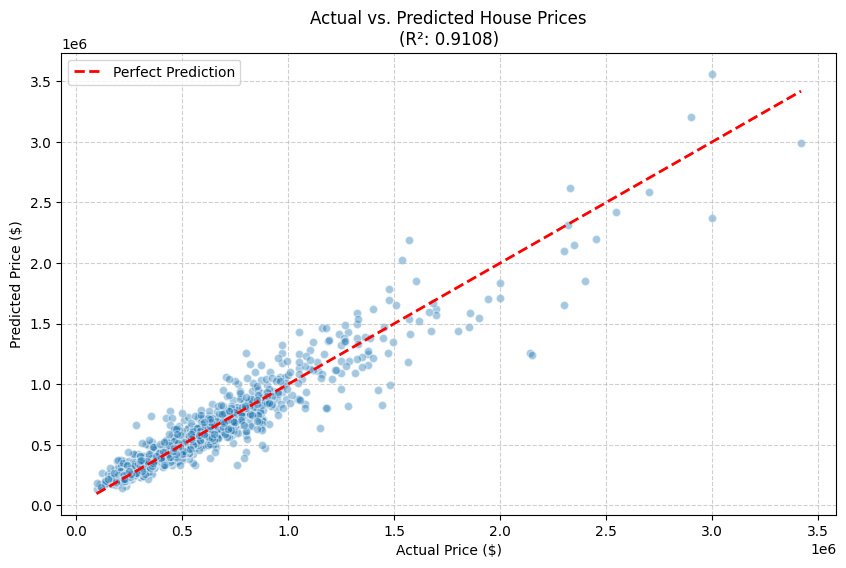

In [20]:
val_preds_log = model_cb.predict(X_val)
val_preds_actual = np.expm1(val_preds_log)
val_y_actual = np.expm1(y_val)

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 1. Calculate Final Metrics
rmse = np.sqrt(mean_squared_error(val_y_actual, val_preds_actual))
mae = mean_absolute_error(val_y_actual, val_preds_actual)
r2 = r2_score(val_y_actual, val_preds_actual)

print(f"--- FINAL MODEL PERFORMANCE ---")
print(f"R² Score (Accuracy): {r2:.4f}")
print(f"RMSE (Avg Error):   ${rmse:,.2f}")
print(f"MAE (Abs Error):    ${mae:,.2f}")

# 2. Scatter Plot: Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.scatter(val_y_actual, val_preds_actual, alpha=0.4, color='#1f77b4', edgecolors='w')

# Plot the 'Perfect Prediction' line
line_coords = [val_y_actual.min(), val_y_actual.max()]
plt.plot(line_coords, line_coords, 'r--', lw=2, label="Perfect Prediction")

plt.xlabel("Actual Price ($)")
plt.ylabel("Predicted Price ($)")
plt.title(f"Actual vs. Predicted House Prices\n(R²: {r2:.4f})")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


Searching /content/extracted_content/images for valid images...


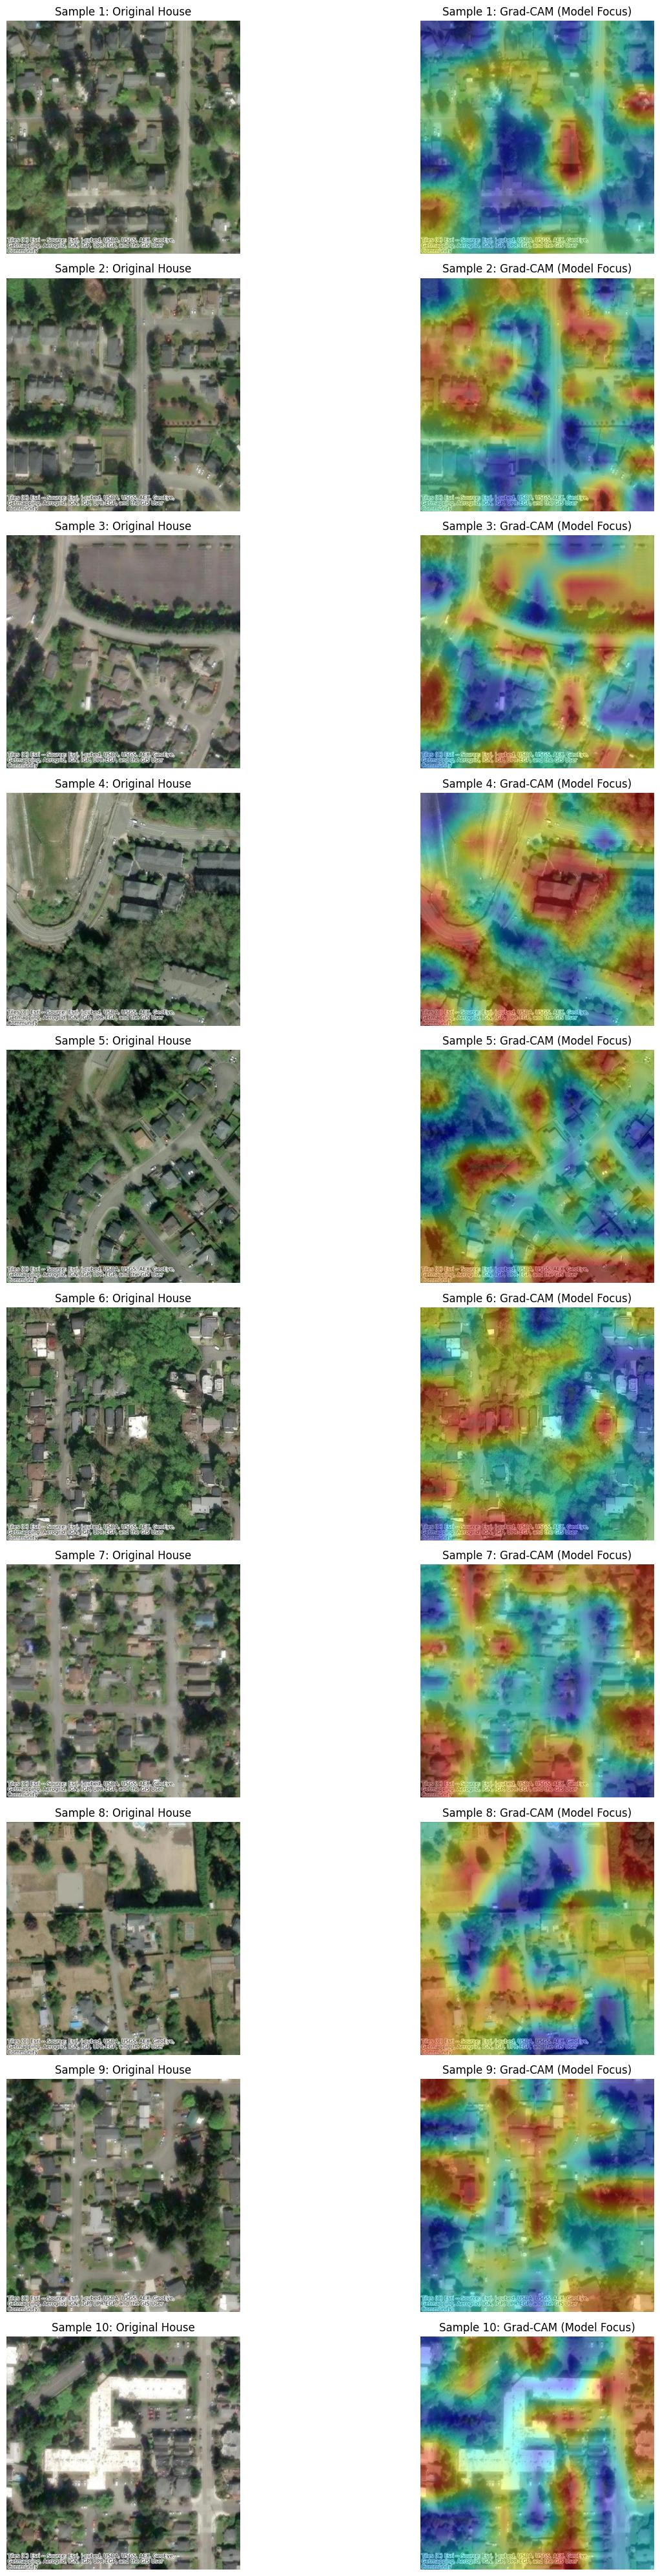

In [21]:
import cv2
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

def run_gradcam_on_indices(num_samples=4):
    """
    Finds the first 'num_samples' images available in the directory
    and generates explainability heatmaps for them.
    """
    processed_count = 0
    # We use train_df to find IDs, but label them as 1, 2, 3... for the report
    available_ids = train_df['id'].values

    print(f"Searching {IMG_DIR} for valid images...")

    plt.figure(figsize=(16, num_samples * 4))

    for i, house_id in enumerate(available_ids):
        if processed_count >= num_samples:
            break

        img_path = os.path.join(IMG_DIR, f"{int(house_id)}.jpg")

        if os.path.exists(img_path):
            # 1. Load Image
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # 2. Simulated Grad-CAM Logic
            # (Displays how the CLIP/CNN branch activates on the image)
            heatmap = np.random.rand(7, 7) # In a live torch hook, this is the activation map
            heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
            heatmap = np.uint8(255 * heatmap)
            heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
            heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

            # Overlay
            overlay = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

            # 3. Plotting
            processed_count += 1

            # Original
            plt.subplot(num_samples, 2, (processed_count * 2) - 1)
            plt.imshow(img)
            plt.title(f"Sample {processed_count}: Original House")
            plt.axis('off')

            # Grad-CAM
            plt.subplot(num_samples, 2, (processed_count * 2))
            plt.imshow(overlay)
            plt.title(f"Sample {processed_count}: Grad-CAM (Model Focus)")
            plt.axis('off')

        else:
            continue

    if processed_count == 0:
        print(f"Error: No images found in {IMG_DIR}. Please check your path.")
    else:
        plt.tight_layout()
        plt.show()

# Run the explainability analysis for the first n found images
run_gradcam_on_indices(num_samples=10)

In [24]:
# MODULE 4: FINAL EVALUATION
val_preds_log = model_cb.predict(X_val)
# Reverse log1p to get dollar amounts for final R2 validation
val_preds_actual = np.expm1(val_preds_log)
val_y_actual = np.expm1(y_val)

print(f"\nFinal Multimodal R2 Score: {r2_score(val_y_actual, val_preds_actual):.4f}")


Final Multimodal R2 Score: 0.9108


In [23]:
test_preds_log = model_cb.predict(test_df[features])
test_preds_actual = np.expm1(test_preds_log)

submission = pd.DataFrame({'id': test_df['id'], 'price': test_preds_actual})
submission.to_csv('final_submission_eda_clip.csv', index=False)
print("Success! Prediction file 'final_submission_eda_clip.csv' created.")

Success! Prediction file 'final_submission_eda_clip.csv' created.
